<a href="https://colab.research.google.com/github/pelegharel/robotics-final/blob/master/wall_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Only run on google collab

In [83]:
!git clone https://github.com/pelegharel/robotics-final.git

Cloning into 'robotics-final'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [85]:
!ls

map_exmaple.png  map.pgm  robotics-final  sample_data


In [0]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
import cv2

In [0]:
def unit_vector(vector):
  return vector / norm(vector)

def unit_vectors(vectors):
    """ Returns the unit vector of the vector.  """
    return vectors / norm(vectors, axis=1).reshape(-1, 1)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

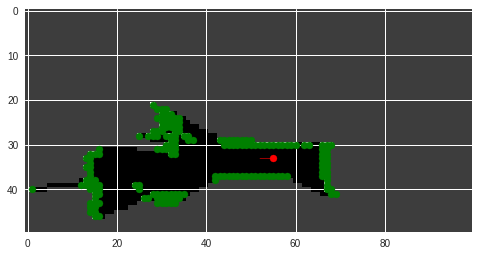

In [0]:
CAVANT = 254
UKNOWN = 205
OCCUPIED = 0

wm = cv2.imread("map.pgm")[150:200, 150:250, 1]
plt.imshow(wm)
robot_pos = (33, 55)

roll = np.pi
robot_rotation = (np.sin(roll), np.cos(roll))

occ_points = np.argwhere(wm == OCCUPIED)
vectors = occ_points - robot_pos

for row, col in occ_points:
  plt.scatter(col, row, color='green')

  
plt.scatter(*robot_pos[::-1], color='red')
plt.arrow(robot_pos[1], robot_pos[0],
          3 * robot_rotation[1],
          3 * robot_rotation[0],
          color='red')

In [0]:
occ_points = np.argwhere(wm == OCCUPIED)
vectors = occ_points - robot_pos
vectors / norm(vectors, axis=1).reshape(-1, 1)

In [0]:
robot_pos

(33, 55)

In [0]:
v1_u = unit_vector(v1)
v2_u = unit_vector(v2)
return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [0]:
v1 = unit_vector(robot_rotation)
vs2 = unit_vectors(vectors)

In [0]:
closest_point = occ_points[np.argmin(norm(occ_points - robot_pos, axis=1))]
closest_point

array([30, 55])

In [0]:
aa = wm == OCCUPIED
[dir(aa) 

In [0]:
v1.reshape(1, 2).shape
v2s.shape

(178, 2)

In [0]:
dir(np)

['ALLOW_THREADS',
 'AxisError',
 'BUFSIZE',
 'CLIP',
 'ComplexWarning',
 'DataSource',
 'ERR_CALL',
 'ERR_DEFAULT',
 'ERR_IGNORE',
 'ERR_LOG',
 'ERR_PRINT',
 'ERR_RAISE',
 'ERR_WARN',
 'FLOATING_POINT_SUPPORT',
 'FPE_DIVIDEBYZERO',
 'FPE_INVALID',
 'FPE_OVERFLOW',
 'FPE_UNDERFLOW',
 'False_',
 'Inf',
 'Infinity',
 'MAXDIMS',
 'MAY_SHARE_BOUNDS',
 'MAY_SHARE_EXACT',
 'MachAr',
 'ModuleDeprecationWarning',
 'NAN',
 'NINF',
 'NZERO',
 'NaN',
 'PINF',
 'PZERO',
 'RAISE',
 'RankWarning',
 'SHIFT_DIVIDEBYZERO',
 'SHIFT_INVALID',
 'SHIFT_OVERFLOW',
 'SHIFT_UNDERFLOW',
 'ScalarType',
 'Tester',
 'TooHardError',
 'True_',
 'UFUNC_BUFSIZE_DEFAULT',
 'UFUNC_PYVALS_NAME',
 'VisibleDeprecationWarning',
 'WRAP',
 '_NoValue',
 '_UFUNC_API',
 '__NUMPY_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__config__',
 '__doc__',
 '__file__',
 '__git_revision__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_add_newdoc_ufunc',
 '_arg',
 '_distributor_init',


In [0]:
np. -v2s[:,1], v2s[:,0]

(array([ 0.91381155,  0.92096725,  0.91531503,  0.90906482,  0.92847669,
         0.92307692,  0.91707006,  0.94498607,  0.94088741,  0.93632918,
         0.93124278,  0.92554696,  0.91914503,  0.95242415,  0.9486833 ,
         0.9444968 ,  0.93979342,  0.93448773,  0.96296402,  0.96      ,
         0.95667388,  0.95292578,  0.9486833 ,  0.97618706,  0.9743912 ,
         0.9723873 ,  0.96476382,  0.96152395,  0.98639392,  0.98442758,
         0.983282  ,  0.98200645,  0.97898042,  0.97717636,  0.97513286,
         0.9701425 ,  0.96707454,  0.98521175,  0.98386991,  0.97854978,
         0.97618706,  0.9486833 ,  0.93979342,  0.92847669,  0.91381155,
         0.89442719,  0.86824314,  0.83205029,  0.78086881,  0.99227788,
         0.99160041,  0.99083017,  0.96476382,  0.95782629,  0.9486833 ,
         0.93632918,  0.91914503,  0.89442719,  0.85749293,  0.8       ,
         0.70710678,  0.5547002 ,  0.31622777, -0.        , -0.31622777,
        -0.5547002 , -0.70710678, -0.8       , -0.8

In [0]:
v1 = unit_vector(robot_rotation)
v2s = unit_vectors(vectors)
cosines = v2s @ v1.reshape(2, 1)
sinuses = 
np.min(np.arccos())

0.0